In [1]:
%cd ..

/home/zaccharie/workspace/fastmri-reproducible-benchmark


In [37]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import glob

import h5py
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

from fourier import FFT2
from utils import crop_center, gen_mask

from mri.numerics.gradient import GradAnalysis2
from mri.numerics.linear import WaveletUD,Wavelet2
from mri.numerics.reconstruct import sparse_rec_condatvu, sparse_rec_fista
from modopt.opt.proximity import SparseThreshold, LinearCompositionProx
from mri.numerics.gradient import GradAnalysis2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

In [4]:
fourier_op = FFT2(np.array([1]))

# Loading input data

In [5]:
val_path = '../singlecoil_val/'
filenames = glob.glob(val_path + '*')

In [6]:
def from_file_to_mask_and_kspace(filename):
    h5_obj = h5py.File(filename)
    image = h5_obj['reconstruction_esc'][()]
    kspace = h5_obj['kspace'][()]
    return image, kspace

In [7]:
file_0 = filenames[5]
images,  kspaces = from_file_to_mask_and_kspace(file_0)

In [8]:
slice_selected = 10
kspace = kspaces[slice_selected]
image = images[slice_selected]

In [9]:
kspace.shape

(640, 368)

In [10]:
image.shape

(320, 320)

# Visualizing input data

<IPython.core.display.Javascript object>


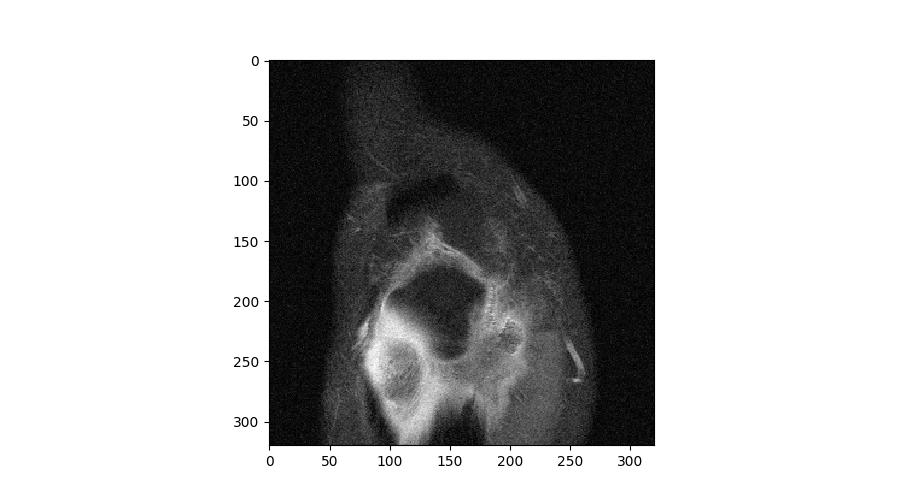

In [11]:
plt.figure()
plt.imshow(image)

<IPython.core.display.Javascript object>


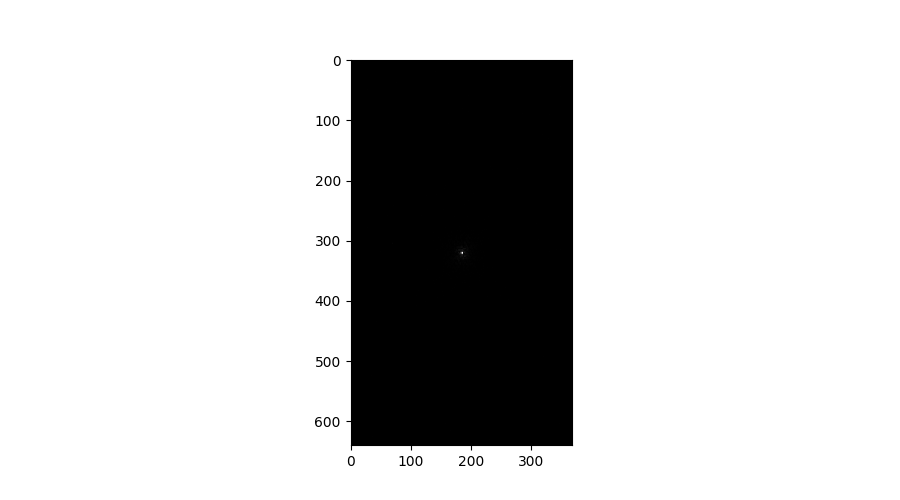

In [12]:
plt.figure()
plt.imshow(np.abs(kspace))

<IPython.core.display.Javascript object>


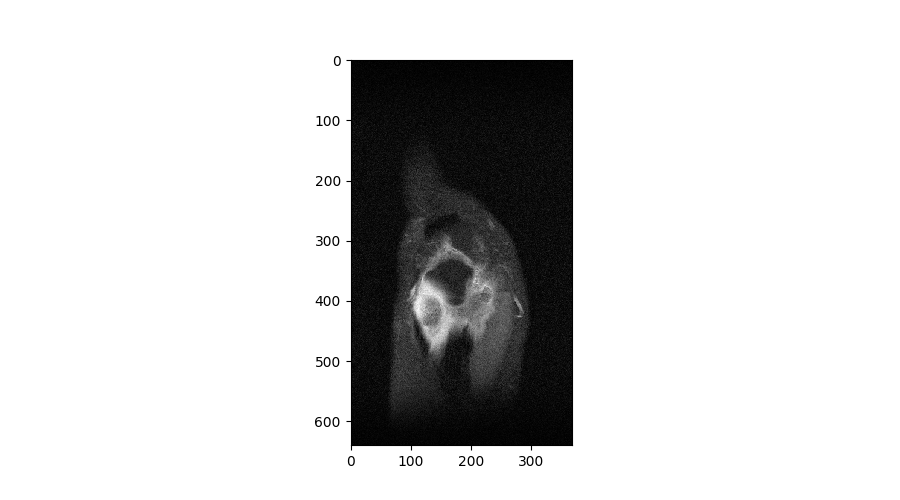

In [13]:
plt.figure()
plt.imshow(np.abs(np.fft.ifftshift(np.fft.ifft2(kspace))))

# Mask generation

In [16]:
accel_factor = 8
mask = gen_mask(kspace, accel_factor=accel_factor)
len(mask) / np.sum(mask)

8.177777777777777

# Create the operators

In [17]:
decimated = False

In [18]:
fourier_mask = np.repeat(mask.astype(np.float)[None, :], kspace.shape[0], axis=0)
fourier_op_masked = FFT2(mask=fourier_mask)
masked_kspace = kspace * fourier_mask

if decimated:
    nb_scales = 4
    wavelet_name = 'db4'
    linear_op = Wavelet2(
        nb_scale=nb_scales,
        wavelet_name=wavelet_name,
        padding='periodization',
    )

    gradient_op = GradAnalysis2(
        data=kspace_data,
        fourier_op=fourier_op)

    # Define the proximity dual/primal operator
    prox_op = LinearCompositionProx(
        linear_op=linear_op,
        prox_op=SparseThreshold(Identity(), None, thresh_type="soft"),
    )
else:
    nb_scales = 4
    wavelet_id = 24
    linear_op = WaveletUD(
        nb_scale=nb_scales,
        wavelet_id=wavelet_id,
        set_norm=1.1,
    )

    gradient_op = GradAnalysis2(
        data=masked_kspace,
        fourier_op=fourier_op_masked)

    # Define the proximity dual/primal operator
    prox_op = SparseThreshold(linear_op, None, thresh_type="soft")
    cost_op = None

<IPython.core.display.Javascript object>


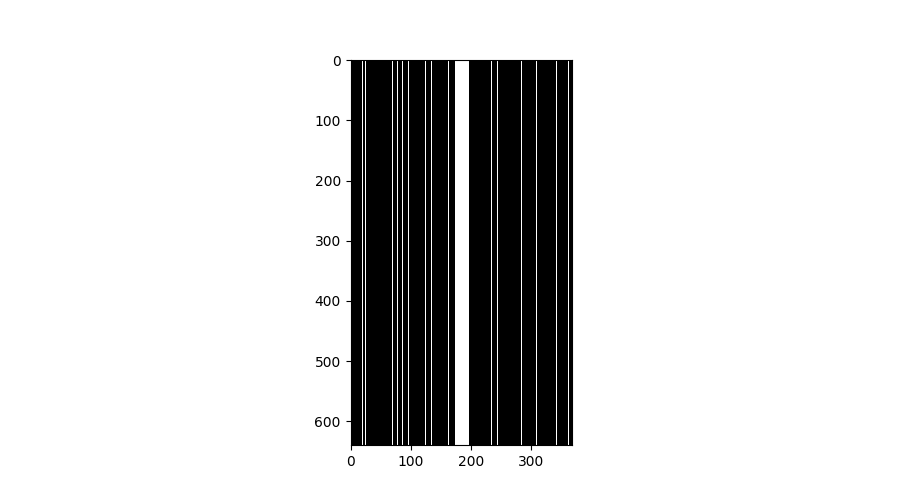

In [19]:
plt.figure()
plt.imshow(np.abs(fourier_mask))

In [20]:
def objective_cost(x):
    return data_fidelity(x) + sparsity(x)

def sparsity(x):
    return mu * np.sum(np.abs(linear_op.op(x)))

def data_fidelity(x):
    return 0.5 * np.linalg.norm(fourier_op_masked.op(x) - masked_kspace)**2

In [21]:
def nrmse(x):
    im = crop_center(x, 320)
    return np.linalg.norm(np.abs(im) - image) / np.mean(image)

def psnr(x):
    im = crop_center(x, 320)
    mse = np.mean((np.abs(im) - image)**2)
    p = 10 * np.log10(np.max(image)**2 / mse)
#     import pdb; pdb.set_trace()
    return p

In [22]:
metrics_ = {
    "cost": {"metric": objective_cost, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
    "nrmse": {"metric": nrmse, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
    "psnr": {"metric": psnr, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
}

## Selecting best mu

In [44]:
n_exp = 10
mus = np.logspace(-7, -5, n_exp)
psnrs = np.empty((n_exp, ))

In [45]:
for i, mu in tqdm_notebook(enumerate(mus), total=n_exp):
    # Start the Condat reconstruction
    cost_op = None
    _, _, _, metrics = sparse_rec_condatvu(
        gradient_op,
        linear_op,
        prox_op,
        cost_op,
        std_est_method=None,
        std_est=0.1,
        mu=mu,
        sigma=10,
        nb_of_reweights=0,
        max_nb_of_iter=50,
        metrics=metrics_,
        metric_call_period=5,
        verbose=0,
    )
    psnrs[i] = metrics['psnr']['values'][-1]

100% (50 of 50) |########################| Elapsed Time: 0:01:00 Time:  0:01:00
100% (50 of 50) |########################| Elapsed Time: 0:01:04 Time:  0:01:04
100% (50 of 50) |########################| Elapsed Time: 0:01:02 Time:  0:01:02
100% (50 of 50) |########################| Elapsed Time: 0:01:00 Time:  0:01:00
100% (50 of 50) |########################| Elapsed Time: 0:01:01 Time:  0:01:01
100% (50 of 50) |########################| Elapsed Time: 0:01:01 Time:  0:01:01
100% (50 of 50) |########################| Elapsed Time: 0:01:00 Time:  0:01:00
100% (50 of 50) |########################| Elapsed Time: 0:01:01 Time:  0:01:01
100% (50 of 50) |########################| Elapsed Time: 0:01:01 Time:  0:01:01
100% (50 of 50) |########################| Elapsed Time: 0:01:00 Time:  0:01:00


<IPython.core.display.Javascript object>


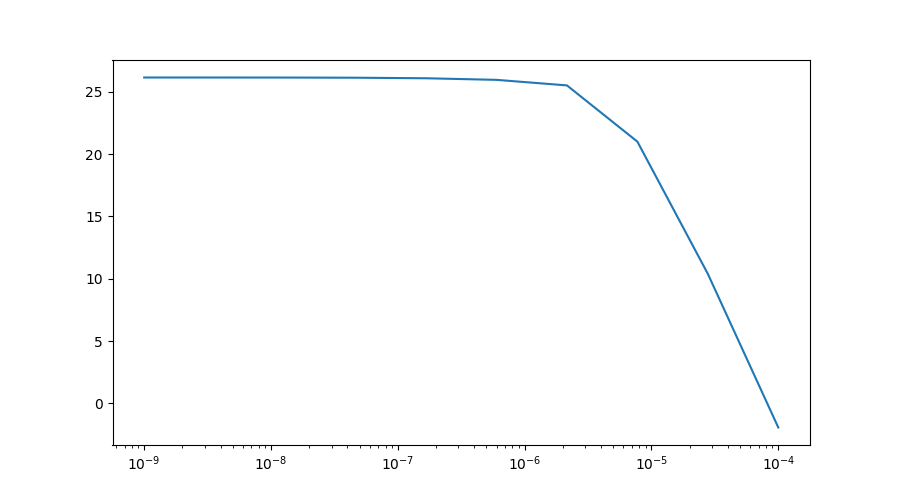

In [46]:
plt.figure()
plt.plot(mus, psnrs)
plt.xscale("log")

In [23]:
mu = 1e-9

In [32]:
max_iter = 300

In [33]:
# Start the Condat reconstruction
cost_op = None
if decimated:
    x_final, _, _, metrics = sparse_rec_fista(
        gradient_op=gradient_op,
        linear_op=Identity(),
        prox_op=prox_op,
        cost_op=cost_op,
        xi_restart=0.96,
        s_greedy=1.1,
        mu=mu,
        restart_strategy='greedy',
        pov='analysis',
        max_nb_of_iter=max_iter,
        metrics=metrics_,
        metric_call_period=5,
        verbose=1,
    )
else:
    x_final, _, _, metrics = sparse_rec_condatvu(
        gradient_op,
        linear_op,
        prox_op,
        cost_op,
        std_est_method=None,
        std_est=0.1,
        mu=mu,
        sigma=10,
        nb_of_reweights=0,
        max_nb_of_iter=max_iter,
        metrics=metrics_,
        metric_call_period=1,
        verbose=1,
    )


   ____   U  ___ u  _   _    ____       _       _____      __     __    _   _
U /"___|   \/"_ \/ | \ |"|  |  _"\  U  /"\  u  |_ " _|     \ \   /"/uU |"|u| |
\| | u     | | | |<|  \| |>/| | | |  \/ _ \/     | |        \ \ / //  \| |\| |
 | |/__.-,_| |_| |U| |\  |uU| |_| |\ / ___ \    /| |\       /\ V /_,-. | |_| |
  \____|\_)-\___/  |_| \_|  |____/ u/_/   \_\  u |_|U      U  \_/-(_/ <<\___/
 _// \\      \\    ||   \\,-.|||_    \\    >>  _// \\_       //      (__) )(
(__)(__)    (__)   (_")  (_/(__)_)  (__)  (__)(__) (__)     (__)         (__)
    
 - mu:  1e-09
 - lipschitz constant:  1.1000000000000003
 - tau:  0.07905138333671825
 - sigma:  10
 - rho:  1.0
 - std:  0.1
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletUD object at 0x7f9a57fc7780> - 4
 - max iterations:  300
 - number of reweights:  0
 - primal variable shape:  (640, 368)
 - dual variable shape:  (10, 640, 368)
----------------------------------------
Starting op

100% (300 of 300) |######################| Elapsed Time: 0:08:39 Time:  0:08:39


 - converged:  False
Done.
Execution time:  1043.986097  seconds
----------------------------------------


<IPython.core.display.Javascript object>


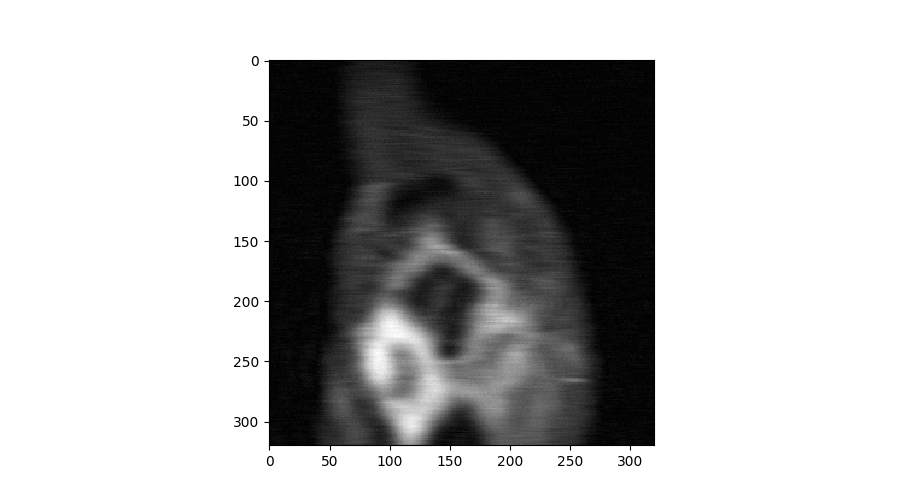

In [34]:
plt.figure()
plt.imshow(crop_center(np.abs(x_final), 320))

<IPython.core.display.Javascript object>


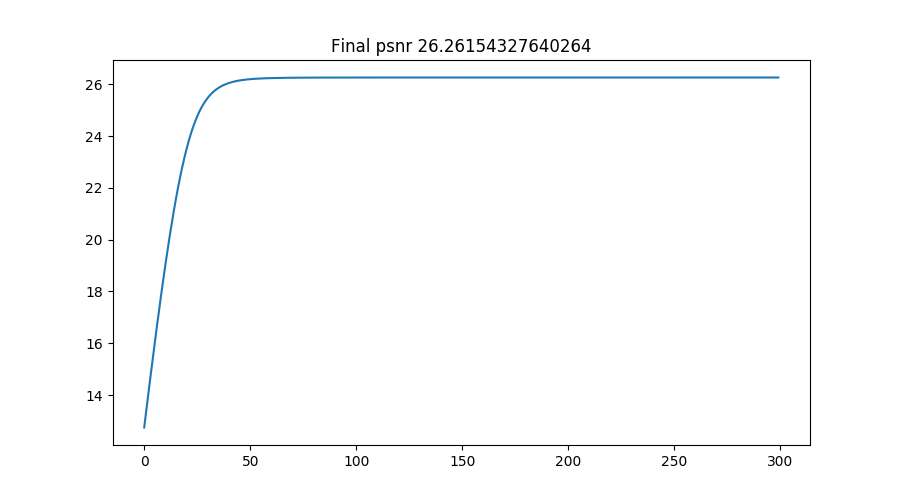

Text(0.5, 1.0, 'Final psnr 26.26154327640264')

In [35]:
plt.figure()
plt.plot(np.array(metrics['psnr']['values']))
plt.title('Final psnr {}'.format(metrics['psnr']['values'][-1]))

In [29]:
zero_filled_reco = np.abs(fourier_op_masked.adj_op(masked_kspace))
psnr(zero_filled_reco)

26.26155883347039